# Pandas Advanced

This notebook builds on pandas fundamentals and focuses on advanced indexing, grouping, time series, and performance patterns.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 30)


## 1. Index Mastery (Beyond Basics)
MultiIndex creation/manipulation, index alignment, and cross-section slicing.


In [5]:
# MultiIndex creation
idx = pd.MultiIndex.from_product(
    [["US", "CA"], ["A", "B", "C"]],
    names=["country", "segment"]
)

s = pd.Series(np.arange(len(idx)), index=idx)
s


country  segment
US       A          0
         B          1
         C          2
CA       A          3
         B          4
         C          5
dtype: int64

In [6]:
# set_index / reset_index

df = pd.DataFrame({
    "country": ["US", "US", "CA", "CA"],
    "segment": ["A", "B", "A", "B"],
    "value": [10, 20, 15, 25]
})

mi = df.set_index(["country", "segment"])
mi


value
country segment       
US      A           10
        B           20
CA      A           15
        B           25

In [7]:
mi.reset_index()


,country,segment,value
0,US,A,10
1,US,B,20
2,CA,A,15
3,CA,B,25


In [8]:
# swaplevel / reorder_levels
mi_swapped = mi.swaplevel(0, 1)
mi_swapped


,,value
segment,country,
A,US,10
B,US,20
A,CA,15
B,CA,25


In [9]:
mi_reordered = mi.reorder_levels([1, 0])
mi_reordered


,,value
segment,country,
A,US,10
B,US,20
A,CA,15
B,CA,25


In [10]:
# .xs() cross-section slicing
mi.xs("US", level="country")


,value
segment,
A,10
B,20


In [11]:
# Index alignment rules: operations align on labels
left = pd.Series([1, 2, 3], index=["a", "b", "c"])
right = pd.Series([10, 20, 30], index=["b", "c", "d"])

left + right  # aligns on index labels, produces NaN where missing


a     NaN
b    12.0
c    23.0
d     NaN
dtype: float64

## 2. Advanced Groupby Patterns
Named aggregations, transform vs apply vs agg, and group-wise normalization.


In [12]:
df = pd.DataFrame({
    "team": ["A", "A", "B", "B", "B"],
    "player": ["p1", "p2", "p3", "p4", "p5"],
    "points": [10, 15, 7, 12, 20],
    "assists": [3, 5, 2, 4, 6]
})

df


,team,player,points,assists
0,A,p1,10,3
1,A,p2,15,5
2,B,p3,7,2
3,B,p4,12,4
4,B,p5,20,6


In [13]:
# Named aggregations
agg = df.groupby("team").agg(
    points_mean=("points", "mean"),
    points_max=("points", "max"),
    assists_sum=("assists", "sum")
)
agg


,points_mean,points_max,assists_sum
team,,,
A,12.5,15,8
B,13.0,20,12


In [14]:
# Multiple aggregations per column
multi_agg = df.groupby("team")["points"].agg(["mean", "min", "max"]) 
multi_agg


,mean,min,max
team,,,
A,12.5,10,15
B,13.0,7,20


In [15]:
# transform (same shape as original) vs apply vs agg

# Group-wise z-score (transform)
points_z = df.groupby("team")["points"].transform(lambda x: (x - x.mean()) / x.std())

# apply is flexible but slower (returns arbitrary shape)
apply_example = df.groupby("team").apply(lambda g: g.nlargest(1, "points"))

points_z, apply_example


/var/folders/t5/pnfh13sd6mx11zzqg0jys72w0000gn/T/ipykernel_21439/2615780259.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  apply_example = df.groupby("team").apply(lambda g: g.nlargest(1, "points"))


(0   -0.707107
 1    0.707107
 2   -0.914991
 3   -0.152499
 4    1.067490
 Name: points, dtype: float64,
        team player  points  assists
 team                               
 A    1    A     p2      15        5
 B    4    B     p5      20        6)

In [16]:
# Group-wise normalization and ranking

df["points_rank"] = df.groupby("team")["points"].rank(ascending=False)
df["points_share"] = df["points"] / df.groupby("team")["points"].transform("sum")

df


,team,player,points,assists,points_rank,points_share
0,A,p1,10,3,2.0,0.400000
1,A,p2,15,5,1.0,0.600000
2,B,p3,7,2,3.0,0.179487
3,B,p4,12,4,2.0,0.307692
4,B,p5,20,6,1.0,0.512821


In [17]:
# Time-based groupby (year, month)

dates = pd.date_range("2024-01-01", periods=8, freq="D")
values = np.arange(8) * 10

ts = pd.DataFrame({"date": dates, "value": values}).set_index("date")

ts.groupby(ts.index.month).mean()


,value
date,
1,35.0


## 3. Window / Rolling / Expanding Ops
rolling, expanding, ewm, grouped rolling, centered windows.


In [18]:
s = pd.Series([1, 2, 3, 4, 5, 6])

s.rolling(window=3).mean()


0    NaN
1    NaN
2    2.0
3    3.0
4    4.0
5    5.0
dtype: float64

In [19]:
# Centered vs trailing windows
s.rolling(window=3, center=True).mean()


0    NaN
1    2.0
2    3.0
3    4.0
4    5.0
5    NaN
dtype: float64

In [20]:
# Expanding (cumulative)
s.expanding().mean()


0    1.0
1    1.5
2    2.0
3    2.5
4    3.0
5    3.5
dtype: float64

In [21]:
# Exponentially weighted moving average
s.ewm(alpha=0.3).mean()


0    1.000000
1    1.588235
2    2.232877
3    2.930517
4    3.676788
5    4.466682
dtype: float64

In [22]:
# Custom rolling function
s.rolling(window=3).apply(lambda x: x.max() - x.min())


0    NaN
1    NaN
2    2.0
3    2.0
4    2.0
5    2.0
dtype: float64

In [23]:
# Grouped rolling

df = pd.DataFrame({
    "team": ["A", "A", "A", "B", "B", "B"],
    "game": [1, 2, 3, 1, 2, 3],
    "points": [10, 12, 9, 7, 14, 11]
})

df["rolling_points"] = (
    df.groupby("team")["points"]
      .rolling(window=2, min_periods=1)
      .mean()
      .reset_index(level=0, drop=True)
)

df


,team,game,points,rolling_points
0,A,1,10,10.0
1,A,2,12,11.0
2,A,3,9,10.5
3,B,1,7,7.0
4,B,2,14,10.5
5,B,3,11,12.5


## 4. Time Series Internals
DatetimeIndex, PeriodIndex, TimedeltaIndex, resampling, time zones.


In [24]:
# DatetimeIndex
rng = pd.date_range("2024-01-01", periods=5, freq="D")

ts = pd.Series([5, 3, 6, 2, 7], index=rng)

ts


2024-01-01    5
2024-01-02    3
2024-01-03    6
2024-01-04    2
2024-01-05    7
Freq: D, dtype: int64

In [25]:
# Resampling vs grouping

ts.resample("2D").mean()


2024-01-01    4.0
2024-01-03    4.0
2024-01-05    7.0
Freq: 2D, dtype: float64

In [26]:
# PeriodIndex
pi = pd.period_range("2024Q1", periods=4, freq="Q")
pi


PeriodIndex(['2024Q1', '2024Q2', '2024Q3', '2024Q4'], dtype='period[Q-DEC]')

In [27]:
# TimedeltaIndex

durations = pd.to_timedelta(["1D", "2D", "3D"])
durations


TimedeltaIndex(['1 days', '2 days', '3 days'], dtype='timedelta64[ns]', freq=None)

In [28]:
# Time-zone aware data

tz_rng = pd.date_range("2024-01-01", periods=3, freq="H", tz="UTC")
tz_series = pd.Series([1, 2, 3], index=tz_rng)

# Convert to US/Eastern

tz_series.tz_convert("US/Eastern")


/var/folders/t5/pnfh13sd6mx11zzqg0jys72w0000gn/T/ipykernel_21439/2135384358.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  tz_rng = pd.date_range("2024-01-01", periods=3, freq="H", tz="UTC")


2023-12-31 19:00:00-05:00    1
2023-12-31 20:00:00-05:00    2
2023-12-31 21:00:00-05:00    3
Freq: h, dtype: int64

In [29]:
# Offsets and business calendars
biz = pd.date_range("2024-01-01", periods=5, freq="B")
biz


DatetimeIndex(['2024-01-01', '2024-01-02', '2024-01-03', '2024-01-04',
               '2024-01-05'],
              dtype='datetime64[ns]', freq='B')

In [30]:
# Irregular time series handling

irregular = pd.Series([1, 4, 2], index=pd.to_datetime(["2024-01-01", "2024-01-03", "2024-01-10"]))

# Reindex to daily, fill missing
irregular.reindex(pd.date_range("2024-01-01", "2024-01-10"), method="ffill")


2024-01-01    1
2024-01-02    1
2024-01-03    4
2024-01-04    4
2024-01-05    4
2024-01-06    4
2024-01-07    4
2024-01-08    4
2024-01-09    4
2024-01-10    2
Freq: D, dtype: int64

## 5. Advanced Joins & Reshaping
merge_asof, joins on index vs columns, pivot vs pivot_table, melt/stack.


In [31]:
# merge_asof: nearest key match (sorted keys required)

left = pd.DataFrame({
    "time": pd.to_datetime(["2024-01-01 09:00", "2024-01-01 09:05", "2024-01-01 09:10"]),
    "price": [100, 101, 102]
}).sort_values("time")

right = pd.DataFrame({
    "time": pd.to_datetime(["2024-01-01 09:02", "2024-01-01 09:07"]),
    "event": ["A", "B"]
}).sort_values("time")

pd.merge_asof(left, right, on="time")


,time,price,event
0,2024-01-01 09:00:00,100,NaN
1,2024-01-01 09:05:00,101,A
2,2024-01-01 09:10:00,102,B


In [32]:
# Join on index vs columns

left = pd.DataFrame({"id": [1, 2, 3], "name": ["Ana", "Ben", "Cara"]}).set_index("id")
right = pd.DataFrame({"id": [2, 3, 4], "team": ["X", "Y", "Z"]}).set_index("id")

left.join(right, how="left")


,name,team
id,,
1,Ana,NaN
2,Ben,X
3,Cara,Y


In [33]:
# Many-to-many join explosion risk

left = pd.DataFrame({"key": [1, 1], "val_l": ["a", "b"]})
right = pd.DataFrame({"key": [1, 1, 1], "val_r": ["x", "y", "z"]})

pd.merge(left, right, on="key")  # 2 x 3 -> 6 rows


,key,val_l,val_r
0,1,a,x
1,1,a,y
2,1,a,z
3,1,b,x
4,1,b,y
5,1,b,z


In [34]:
# pivot vs pivot_table

df = pd.DataFrame({
    "city": ["A", "A", "B", "B"],
    "year": [2023, 2024, 2023, 2024],
    "value": [10, 12, 8, 9]
})

pivoted = df.pivot(index="city", columns="year", values="value")
pivoted


year,2023,2024
city,,
A,10,12
B,8,9


In [35]:
# pivot_table supports aggregation

df_dup = pd.DataFrame({
    "city": ["A", "A", "A"],
    "year": [2024, 2024, 2024],
    "value": [10, 12, 14]
})

pd.pivot_table(df_dup, index="city", columns="year", values="value", aggfunc="mean")


year,2024
city,
A,12.0


In [36]:
# melt / stack / unstack

df = pd.DataFrame({
    "id": [1, 2],
    "x": [10, 20],
    "y": [30, 40]
})

melted = df.melt(id_vars=["id"], value_vars=["x", "y"], var_name="var", value_name="val")

melted


,id,var,val
0,1,x,10
1,2,x,20
2,1,y,30
3,2,y,40


In [37]:
stacked = df.set_index("id").stack()
stacked


id   
1   x    10
    y    30
2   x    20
    y    40
dtype: int64

In [38]:
unstacked = stacked.unstack()
unstacked


,x,y
id,,
1,10,30
2,20,40


## 6. Memory & Performance
Categorical dtype, nullable dtypes, chunked processing, vectorization patterns.


In [39]:
# Copy vs view semantics (pandas often copies)

df = pd.DataFrame({"a": [1, 2, 3], "b": [4, 5, 6]})

slice_df = df[["a", "b"]]    # likely a new object
slice_df is df


False

In [40]:
# Categorical dtype to save memory

cities = pd.Series(["Austin", "Austin", "Boston", "Austin", "Boston"], dtype="category")
cities.dtype


CategoricalDtype(categories=['Austin', 'Boston'], ordered=False, categories_dtype=object)

In [41]:
# Nullable dtypes

s = pd.Series([1, None, 3], dtype="Int64")
s


0       1
1    <NA>
2       3
dtype: Int64

In [42]:
# Chunked processing

csv_path = "big_sample.csv"

pd.DataFrame({"x": np.arange(1000), "y": np.random.randn(1000)}).to_csv(csv_path, index=False)

chunk_sums = []
for chunk in pd.read_csv(csv_path, chunksize=200):
    chunk_sums.append(chunk["y"].sum())

sum(chunk_sums)


np.float64(-57.80999274374662)

In [43]:
# Vectorization pattern

df = pd.DataFrame({"x": np.arange(5), "y": np.arange(5, 10)})

# Avoid loops, use vectorized ops

df["z"] = df["x"] * 2 + df["y"]

df


,x,y,z
0,0,5,5
1,1,6,8
2,2,7,11
3,3,8,14
4,4,9,17


## 7. Advanced Indexing & Assignment
Boolean indexing pitfalls, chained assignment, .loc vs .iloc, masked assignment.


In [44]:
df = pd.DataFrame({"a": [1, 2, 3, 4], "b": [10, 20, 30, 40]})

# Boolean indexing
mask = df["a"] % 2 == 0

filtered = df[mask]
filtered


,a,b
1,2,20
3,4,40


In [45]:
# Chained assignment (avoid)
# df[mask]["b"] = 999  # SettingWithCopyWarning

# Use .loc for safe mutation

df.loc[mask, "b"] = 999

df


,a,b
0,1,10
1,2,999
2,3,30
3,4,999


In [46]:
# Index alignment during assignment

s = pd.Series([100, 200], index=[0, 3])

df["b"] = s  # aligns on index, introduces NaN for missing

df


,a,b
0,1,100.0
1,2,NaN
2,3,NaN
3,4,200.0


## 8. Custom Functions at Scale
Use NumPy inside pandas pipelines and avoid Python loops.


In [47]:
df = pd.DataFrame({"a": np.arange(5), "b": np.arange(5, 10)})

def fast_fn(x):
    # vectorized inside pandas
    return np.sqrt(x**2 + 1)

out = df["a"].pipe(fast_fn)
out


0    1.000000
1    1.414214
2    2.236068
3    3.162278
4    4.123106
Name: a, dtype: float64

In [48]:
# Broadcasting tricks with DataFrames

A = pd.DataFrame(np.arange(6).reshape(3, 2), columns=["x", "y"])

# Subtract column means (broadcast across rows)
A - A.mean(axis=0)


,x,y
0,-2.0,-2.0
1,0.0,0.0
2,2.0,2.0


## 9. Data Validation & Consistency
Schema checks, duplicate detection, integrity checks after joins.


In [49]:
df = pd.DataFrame({
    "id": [1, 2, 2, 3],
    "value": [10, 20, 20, 30]
})

# Detect duplicates on multiple keys

df.duplicated(subset=["id", "value"], keep=False)


0    False
1     True
2     True
3    False
dtype: bool

In [50]:
# Integrity check after join

left = pd.DataFrame({"id": [1, 2, 3], "x": [10, 20, 30]})
right = pd.DataFrame({"id": [2, 3], "y": [200, 300]})

joined = left.merge(right, on="id", how="left", validate="one_to_one")
joined


,id,x,y
0,1,10,NaN
1,2,20,200.0
2,3,30,300.0


In [51]:
# Missing-data propagation

s = pd.Series([1.0, np.nan, 3.0])

s + 1  # NaN propagates


0    2.0
1    NaN
2    4.0
dtype: float64

## 10. Interoperability & Pipelines
Pandas <-> NumPy <-> matplotlib, scikit-learn, and method chaining.


In [52]:
# Pandas -> NumPy

df = pd.DataFrame({"x": [1, 2, 3], "y": [4, 5, 6]})
arr = df.to_numpy()
arr


array([[1, 4],
       [2, 5],
       [3, 6]])

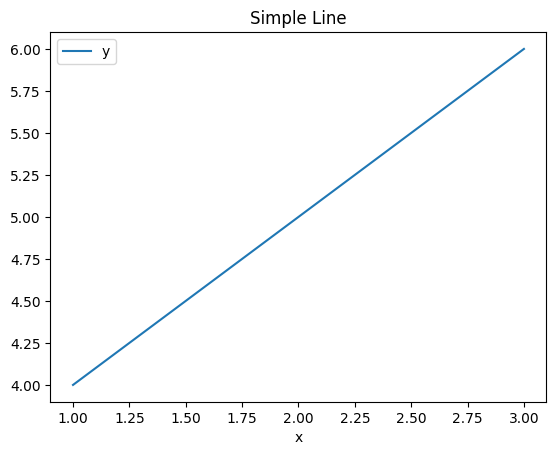

In [53]:
# Pandas -> matplotlib

ax = df.plot(kind="line", x="x", y="y", title="Simple Line")
plt.show()


In [54]:
# Pandas -> scikit-learn (if installed)
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaled = scaler.fit_transform(df[["x", "y"]])
# scaled


In [55]:
# Method chaining with .pipe

def add_ratio(df):
    return df.assign(ratio=df["y"] / df["x"])

chained = (
    df
    .query("x > 1")
    .pipe(add_ratio)
    .sort_values("ratio", ascending=False)
)

chained


,x,y,ratio
1,2,5,2.5
2,3,6,2.0
